# Derivation of the level set function for SLIDE interface model 3.2

In [1]:
%matplotlib widget
import sympy as sp
import numpy as np
import matplotlib.pylab as plt
from mpl_toolkits.mplot3d import Axes3D
# import ipyvolume as ipv
import ipywidgets as ipw
sp.init_printing()

![image.png](f_smooth_cap.png)

# Variables

**Stress variables**

$x$ corresponds to $\sigma_N$ and $y$ corresponds to $\sigma_T$

In [2]:
x, y = sp.symbols('x, y')

**Unknown parameters of the ellipse cap function**

In [3]:
x_c = sp.symbols('x_c') # center point of an ellipse
a = sp.symbols('a', nonnegative=True)
b = sp.symbols('b', nonnegative=True)
c = sp.symbols('c', positive=True)

**Material parameters**

In [4]:
x_0 = sp.symbols('x_0')
x_bar, y_bar = sp.symbols(r'x_bar, y_bar', nonnegative=True )
m = sp.symbols('m')

# Mid part of the threshold function

The linear part of the thresshold function is introduced as
\begin{align}
f_\mathrm{lin} :=
|y| - \bar{y} + m(x - x_0)
\end{align}
where $x_0$ denotes the reference position at which $y = \pm \bar{y}$

In [5]:
f_mid_ = sp.sqrt( y**2 ) - (y_bar - m * (x-x_0))
get_f_mid = sp.lambdify((x, y, y_bar, m), f_mid_)
f_mid_

# Cap function

It is introduced in form of an ellipse centered at the position ($x_c, 0$), i.e.
\begin{align}
f_\mathrm{ell} := \sqrt{\dfrac{y^2}{b^2} + \dfrac{(x - x_0 - x_\mathrm{c})^2}{a^2}} - c
\end{align}
The parameters $a, b, c$ and $x_\mathrm{c}$ are determined based on the compatibility and continuity conditions along the transition between $f_\mathrm{lin}$ and $f_\mathrm{ell}$.

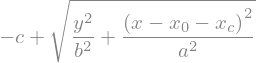

In [6]:
f_cap_ = sp.sqrt( (x-x_0-x_c)**2/a**2 + y**2/b**2 ) - c
f_cap_

Construct the derivatives

In [7]:
df_cap_dx_ = f_cap_.diff(x)
df_cap_dy_ = f_cap_.diff(y)

# Compatibility and smoothness conditions specified in the figure above

\begin{align}
\left. f_\mathrm{ell} \right|_{x = \bar{x}, y = 0} &= 0 \\
\left. f_\mathrm{ell} \right|_{x=x_0, y=\bar{y}} &= 0 \\
\left.
\dfrac{f_{\mathrm{ell},x}}{f_{\mathrm{ell},y}
}
\right|_{x=x_\mathrm{c}, y=\bar{y}}
&= -m
\end{align}

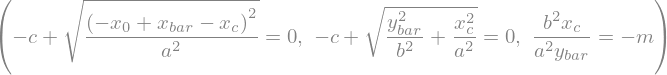

In [8]:
eq1 = sp.Eq( f_cap_.subs({x:x_bar, y:0}), 0 )
eq2 = sp.Eq( f_cap_.subs({x:x_0, y:y_bar}), 0)
eq3 = sp.Eq( ( -df_cap_dx_ / df_cap_dy_).subs({x:x_0, y:y_bar}), -m)
eq1, eq2, eq3

Solve for $a, b$ and $x_c$

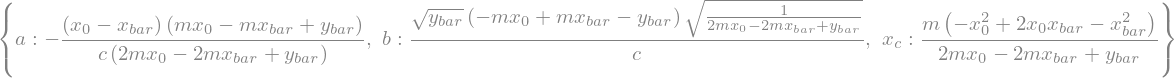

In [9]:
abx_subs = sp.solve({eq1,eq2,eq3},{a,b,x_c})[0]
abx_subs

# Continuity between $f_\mathrm{mid}$ and $f_\mathrm{cap}$


**Require an identical value for**
\begin{align}
f_\mathrm{mid}(x_c, 0) = f_\mathrm{cap}(x_c,0)
\end{align}

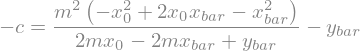

In [11]:
f_mid_c_ = f_mid_.subs({x:abx_subs[x_c]+x_0,y:0})
f_cap_abx_ = f_cap_.subs(abx_subs)
f_cap_abxc_ = f_cap_abx_.subs({x:abx_subs[x_c]+x_0,y:0})
eq4 = sp.Eq( f_cap_abxc_, f_mid_c_ )
eq4

Which can be used to express $c$

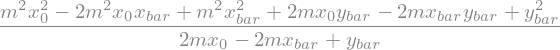

In [12]:
c_solved = sp.solve(eq4, c)[0]
sp.simplify(c_solved)

Substitute back the $f_\mathrm{cap}$ to obtain its resolved form

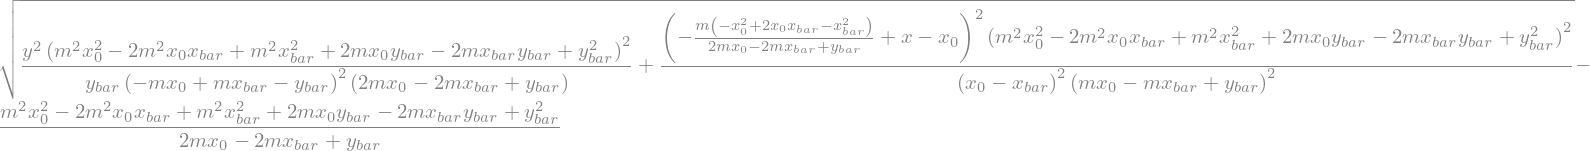

In [13]:
f_cap_solved_ = f_cap_abx_.subs(c, c_solved)
f_cap_solved_

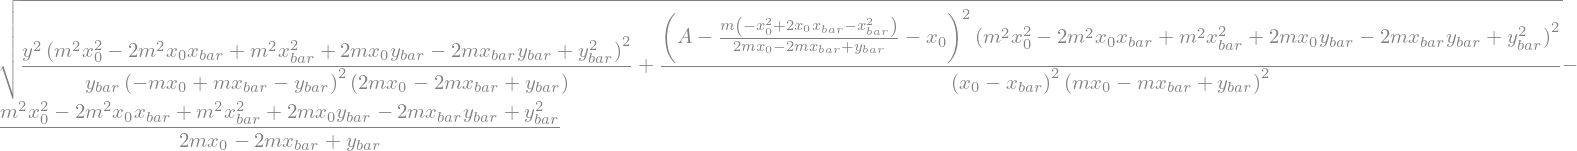

In [14]:
A = sp.symbols('A')
f_cap_solved_.subs(x,A)

# Test the results

In [15]:
_x_0=-3
_x_bar=-5
_y_bar=3
_m=.3

The value in the denominator must not be equal to 0

In [16]:
m_limit_ = sp.solve(2*x_bar * m + y_bar, m)[0]
_m_limit = m_limit_.subs({x_bar:_x_bar, y_bar:_y_bar})
_m_limit

In [17]:
if _m < _m_limit * sp.sign(_x_bar - _x_0):
    print('Take care')

Test the obtained position of $x_c$

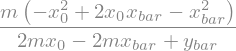

In [18]:
x_c_ = abx_subs[x_c]
x_c_

In [19]:
get_x_c = sp.lambdify((x_bar, y_bar, m, x_0), x_c_, 'numpy' )
_x_c = get_x_c(_x_bar, _y_bar, _m, _x_0)
_x_c

# Domain separation for $f_\mathrm{cap}$ and $f_\mathrm{mid}$

Define the transition between cap and mid domains by defining a connection 
line between [$x_c$,0]-[0,$\bar{\tau}$]. 

In [20]:
y_trans_ = (-y_bar / (x_c) * (x - x_0 -x_c)).subs(x_c, x_c_)
f_cap_domain_ = sp.sign(x_bar-x_0) * sp.sign(-m) * (sp.Abs(y) - y_trans_)  > 0

In [21]:
x_trans = np.linspace(_x_c, _x_0, 10)
get_y_trans = sp.lambdify((x, x_bar, y_bar, m, x_0), y_trans_)
y_trans = get_y_trans(x_trans, _x_bar, _y_bar, _m, _x_0)
x_trans, y_trans

(array([-0.28571429, -0.58730159, -0.88888889, -1.19047619, -1.49206349,
        -1.79365079, -2.0952381 , -2.3968254 , -2.6984127 , -3.        ]),
 array([31.5       , 28.33333333, 25.16666667, 22.        , 18.83333333,
        15.66666667, 12.5       ,  9.33333333,  6.16666667,  3.        ]))

In [22]:
get_y_trans(_x_c, _x_bar, _y_bar, _m, _x_0)

# Composed smooth level set function $f_\mathrm{full}(x,y)$

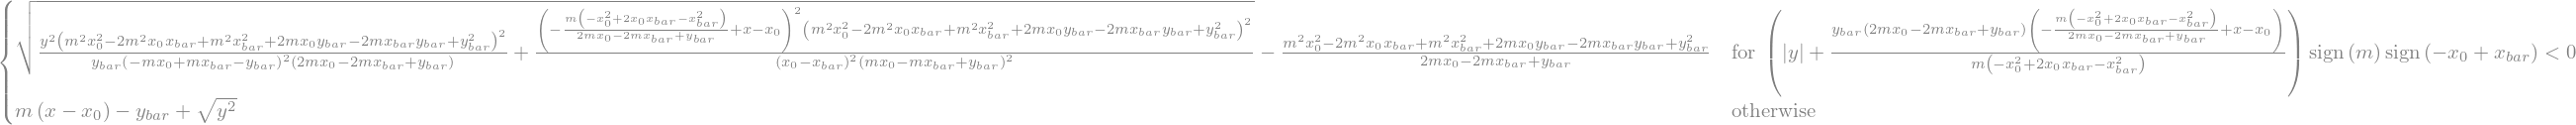

In [23]:
f_full_ = sp.Piecewise(
    (f_cap_solved_, f_cap_domain_),
    (f_mid_, True)
)
get_f_full = sp.lambdify( (x,y,x_bar,y_bar,m,x_0), f_full_, 'numpy')
f_full_

# Visualization

Evaluate the threshold function within an orthogonal grid

In [24]:
X_a, Y_a = np.mgrid[-10:10:210j,-10:10:210j]
Z_a = get_f_full(X_a, Y_a, _x_bar, _y_bar, _m, _x_0)

In [25]:
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1, 1, 1)
ax.contour(X_a,Y_a,Z_a, levels=8)
ax.plot([_x_0],[_y_bar],marker='o')
ax.plot([_x_bar],[0], marker='o', color='red')
ax.plot([_x_c+_x_0],[0], marker='o', color='green')
ax.set_aspect('equal')
#ax.plot(x_trans, y_trans);

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [26]:
if False:
    ipv.figure(width=700, height=500)
    ipv.plot_surface(X_a, Y_a, Z_a)
    ipv.plot_surface(X_a, Y_a, np.ones_like(Z_a), color='blue')
    ipv.xlabel(r'sig')
    ipv.ylabel(r'tau')
    ipv.zlabel('f')
    ipv.show()

# Composed level set function with two caps

In [27]:
f_t, f_c, f_c0, tau_bar = sp.symbols('f_t, f_c, f_c0, tau_bar')
subs_tension = {x_0:0, x_bar:f_t, y_bar:tau_bar}
subs_shear = {y_bar:tau_bar, x_0:0}
subs_compression = {x_0: -f_c0, x_bar:-f_c,  y_bar: tau_bar-m*(-f_c0) }

In [28]:
f_solved_ = sp.Piecewise(
    (f_cap_solved_.subs(subs_tension), f_cap_domain_.subs(subs_tension)),
    (f_cap_solved_.subs(subs_compression), f_cap_domain_.subs(subs_compression)),
    (f_mid_.subs(subs_shear), True)
)

In [29]:
get_f_solved = sp.lambdify( (x,y,f_t,f_c,f_c0,tau_bar,m), f_solved_, 'numpy')

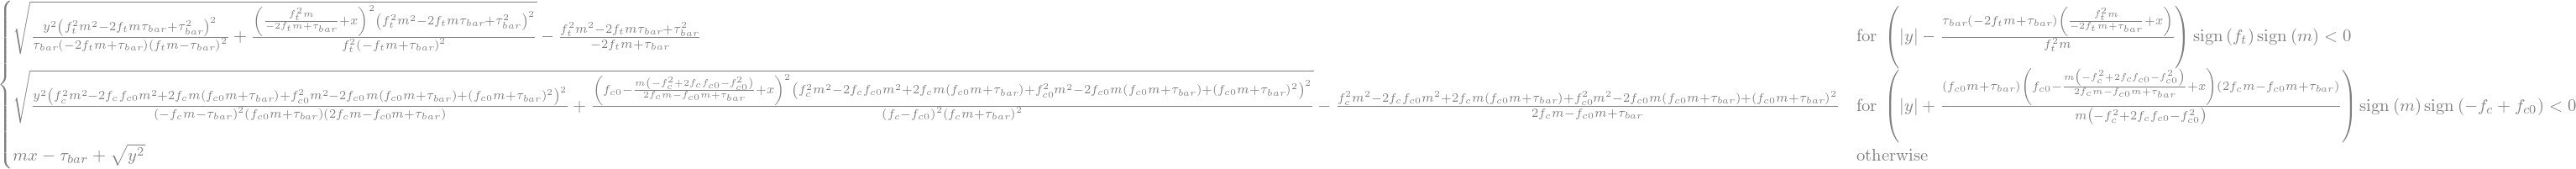

In [30]:
f_solved_

In [33]:
import ipywidgets as ipw
import ipyvolume as ipv

In [39]:
if True:
    ipv.figure(width=1000, height=500)

    max_f_c = 100
    max_f_t = 10
    max_tau_bar = 20

    default_mp = [('f_t', 5, 1, max_f_t),
                 ('f_c', 80, 10, max_f_c),
                 ('f_c0', 30, 5, 90),
                 ('tau_bar', 5, 1, max_tau_bar),
                 ('m', 0.1, 0.0001, 0.5)]

    X_2, Y_2 = np.mgrid[-max_f_c:max_f_t:210j,-max_tau_bar:max_tau_bar:210j]

    sliders_mp = { name: ipw.FloatSlider(
        description=name, value=val, 
        min=minv, max=maxv, step=(maxv-minv)/40, 
        continuous_update=False) 
        for name, val, minv, maxv in default_mp 
    }

    def plot(**mp):
        Z_solved = get_f_solved(X_2,Y_2,**mp)
        ipv.clear()
        ipv.plot_surface(X_a, Y_a, Z_solved)
        ipv.plot_surface(X_a, Y_a, np.ones_like(Z_a), color='gray')
        ipv.xlabel(r' ')
        ipv.ylabel(r' ')
        ipv.zlabel(r' ')
        ipv.show()

    ipw.interact( plot, **sliders_mp );

interactive(children=(FloatSlider(value=5.0, continuous_update=False, description='f_t', max=10.0, min=1.0, st…